# End-to-End Machine Learning Project


## Frame the Problem

1- How does the company expect to use and benefit from this model?

> The model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

2- What is the current solution looks like (if any)?

> the district housing prices are currently estimated manually by experts. This is costly and time-consuming, and their estimates are not great. This is why the company thinks that it would be useful to train a model to predict a district’s median housing price given other data about that district.

3- is it supervised, unsupervised, or Reinforcement Learning? 

> supervised learning

4- Is it a classification task, a regression task, or something else? 

> a regression task

5- Should you use batch learning or online learning techniques?

> batch learning since he data is small enough to fit in memory.

6- How should performance be measured?

> A typical performance measure for regression problems is the Root Mean Square Error (RMSE). Suppose that there are many outlier districts, you may consider using the Mean Absolute Error (MAE).


the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred

7- List the assumptions you (or others) have made so far.

> what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves?

8- Verify assumptions if possible.

> Fortunately, after talking with the team in charge of the downstream system, you are confident that they do indeed need the actual prices, not just categories.

## Get the Data

In [8]:
import pandas as pd
import os

def load_housing_data(housing_path='datasets/housing'):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
df = load_housing_data()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37

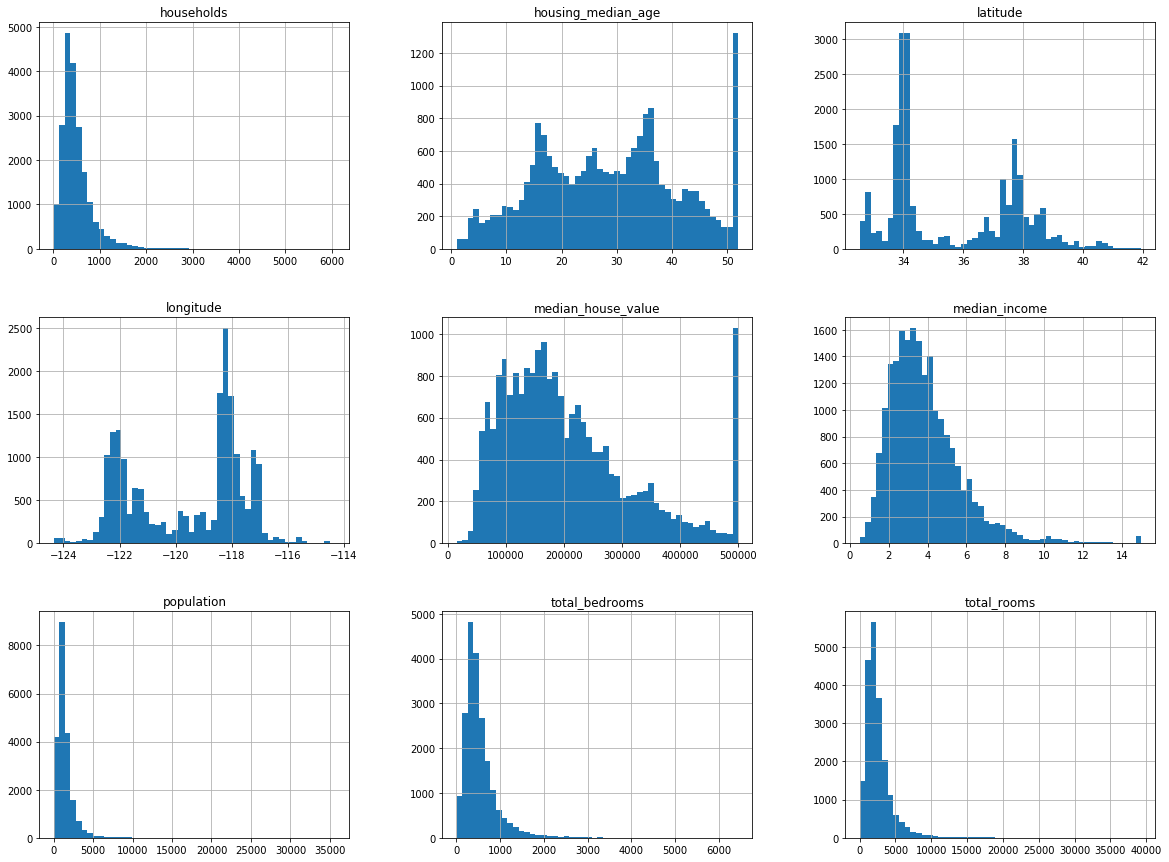

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline   


df.hist(bins=50, figsize=(20,15))
plt.show()

you can see that slightly over 800 districts have a median_house_value equal to about $100,000.



## Create a Test Set

In [17]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

```python
>>> np.random.permutation(4)
array([0, 1, 3, 2])
```

In [41]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [42]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [43]:
housing_with_id = df.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [44]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [45]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [57]:
df["income_cat"] = np.ceil(df["median_income"] / 1.5)

In [58]:
df.income_cat.value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

In [60]:
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,3.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,3.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,3.0


In [61]:
df["income_cat"].where(df["income_cat"] < 5, 5.0, inplace=True)

In [62]:
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,3.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,3.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,3.0


In [63]:
df.income_cat.value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [65]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [66]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [67]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [68]:
housing = strat_train_set.copy()

In [509]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

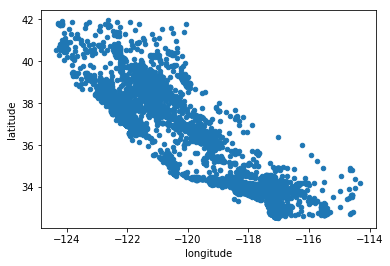

In [69]:
housing.plot(kind="scatter", x="longitude", y="latitude")

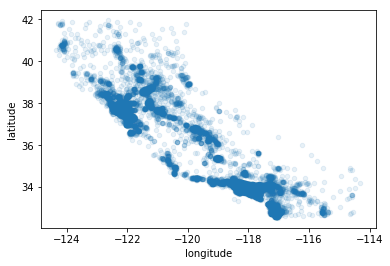

In [70]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

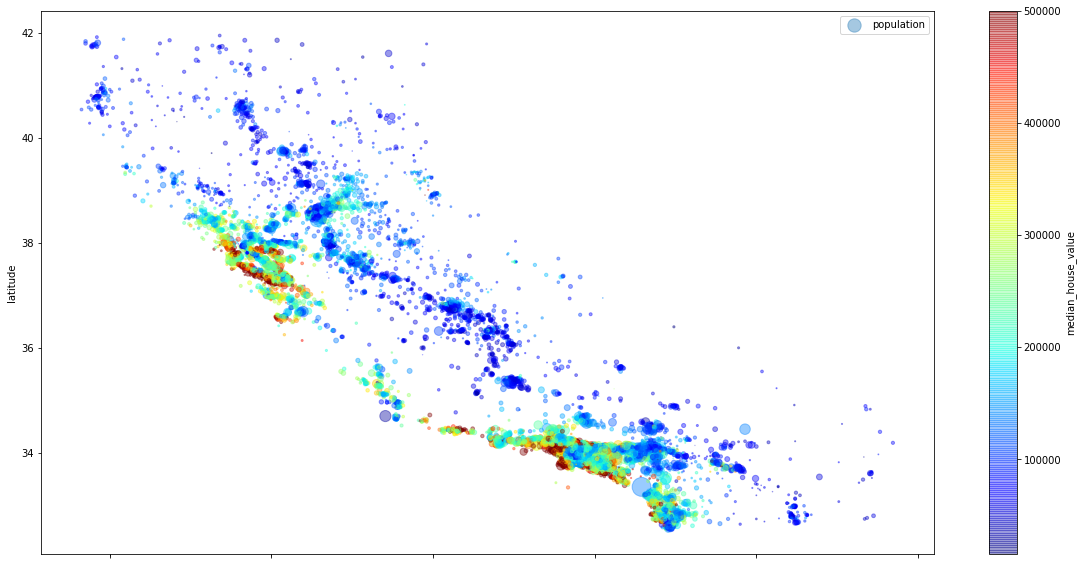

In [85]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(20,10),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density

### Looking for Correlations

In [86]:
corr_matrix = housing.corr()

In [87]:
# how much each attribute correlates with the median house value:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

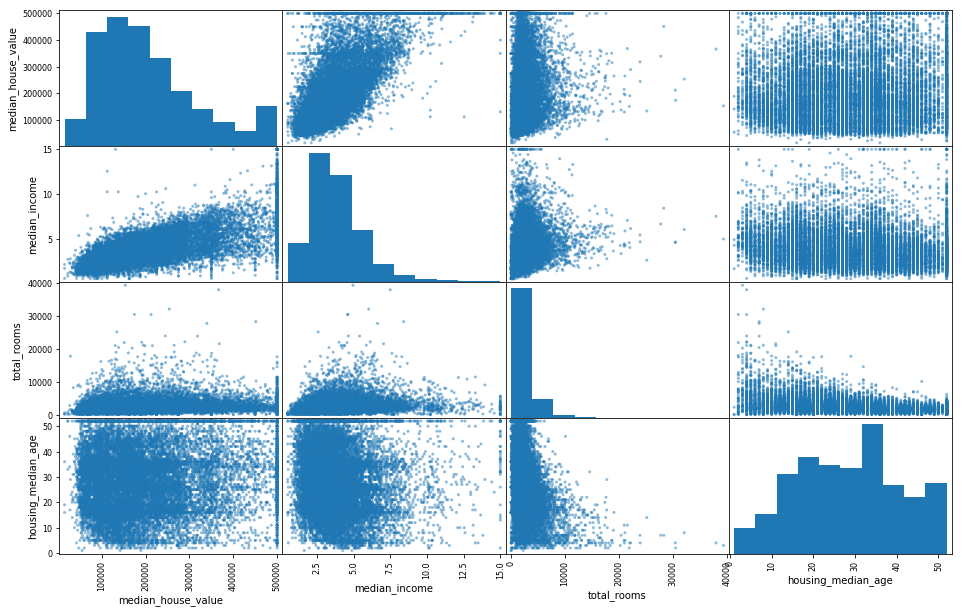

In [90]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(16, 10));

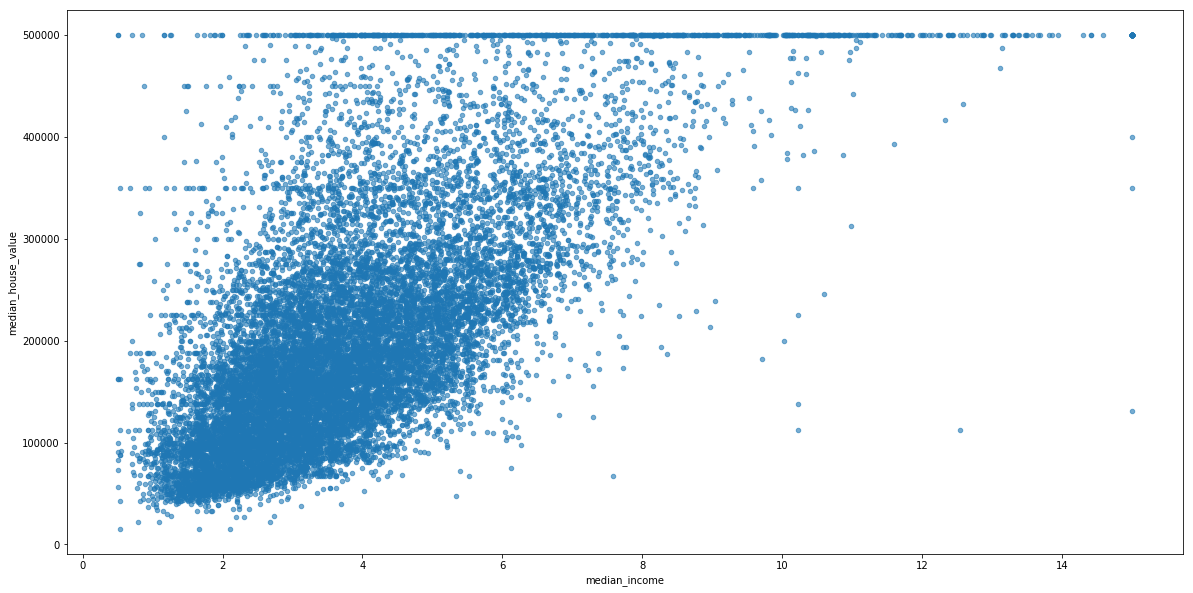

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.6, figsize=(20,10));

### Experimenting with Attribute Combinations

In [94]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [95]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

 houses with a lower bedroom/room ratio tend to be more expensive

## Prepare the Data for Machine Learning Algorithms

In [96]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [145]:
type(housing)

pandas.core.frame.DataFrame

### Data Cleaning

```python
housing.dropna(subset=["total_bedrooms"])    # option 1 Get rid of the corresponding districts.
housing.drop("total_bedrooms", axis=1)       # option 2 Get rid of the whole attribute.
median = housing["total_bedrooms"].median()  # option 3 Set the values to some value
housing["total_bedrooms"].fillna(median, inplace=True)
```

Scikit-Learn provides a handy class to take care of missing values: `Imputer`

In [97]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [98]:
housing_num = housing.drop("ocean_proximity", axis=1) # only numbers for imputer (i.e. estimator)

In [105]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [99]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.

In [100]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [101]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [111]:
housing_num.shape

(16512, 8)

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [102]:
X = imputer.transform(housing_num)

In [112]:
X.shape

(16512, 8)

In [103]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [104]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Handling Text and Categorical Attributes

In [106]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers.

In [355]:
type(housing_cat)

pandas.core.series.Series

In [107]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [108]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [110]:
housing_cat_encoded.shape

(16512,)

In [114]:
housing_cat_encoded.reshape(-1,1).shape

(16512, 1)

In [109]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [115]:
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # or first fit(), then transform()
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [116]:
housing_cat_1hot.toarray().shape

(16512, 5)

In [117]:
from sklearn.preprocessing import CategoricalEncoder # or get from notebook
cat_encoder = CategoricalEncoder()

housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

ImportError: cannot import name 'CategoricalEncoder'

In [123]:
import sklearn
sklearn.__version__
# thus, we need 0.20.0 for CategoricalEncoder

'0.19.1'

### Custom Transformers

In [124]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [125]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature Scaling

. `MinMaxScaler`

. `StandardScaler`

### Transformation Pipelines

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

All but the last estimator must be transformers (i.e., they must have a fit_transform() method)

In [417]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [426]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        housing_encoded, housing_categories = X["ocean_proximity"].factorize()
        return housing_encoded.reshape(-1,1)
    def categories(self,X):
        housing_encoded, housing_categories = X["ocean_proximity"].factorize()
        return housing_categories

In [435]:
type(housing_num)

pandas.core.frame.DataFrame

In [427]:
num_attribs = list(housing_num)

In [434]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [552]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', CustomEncoder()),
        ('onehotencoder', OneHotEncoder())
    ])

In [553]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [431]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [432]:
housing_prepared.toarray()

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [433]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model

In [436]:
housing_labels.shape

(16512,)

In [437]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() ##########

lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [438]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60465002  317768.80710678  210956.43324342   59218.98859436
  189747.55851237]


In [439]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [440]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

In [441]:
lin_rmse

68628.198198489219

In [442]:
lin_reg.score(housing_prepared, housing_labels)

0.64816248428044276

the features do not provide enough information to make good predictions, or that the model is not powerful enough.

In [443]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor() ##########

tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [444]:
>>> housing_predictions = tree_reg.predict(housing_prepared)
>>> tree_mse = mean_squared_error(housing_labels, housing_predictions)
>>> tree_rmse = np.sqrt(tree_mse)
>>> tree_rmse

0.0

Of course, it is much more likely that the model has badly overfit the data.

### Better Evaluation Using Cross-Validation

In [445]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [447]:
def display_scores(scores):
...     print("Scores:", scores)
...     print("Mean:", scores.mean())
...     print("Standard deviation:", scores.std()) # a measure of how precise this estimate is (i.e., its standard deviation).
...
>>> display_scores(tree_rmse_scores)

Scores: [ 68894.3364373   67451.54702578  72560.89952468  69227.44003867
  69767.6156805   74417.9209042   70963.72893776  71478.92827741
  76319.80882723  70134.15632129]
Mean: 71121.6381975
Standard deviation: 2548.28272997


In [448]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
...                              scoring="neg_mean_squared_error", cv=10)
...
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73844183  66960.11806939  70347.95242152  74739.570533
  68031.13388503  71193.84183373  64969.63057397  68281.61137959
  71552.91569783  67665.10080678]
Mean: 69052.4613643
Standard deviation: 2731.67400455


the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [449]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor() ##########

forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [450]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

In [451]:
forest_rmse

22378.094374933215

In [452]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [453]:
display_scores(forest_rmse_scores)

Scores: [ 51387.75815141  50538.59655441  52994.72342923  54401.55021992
  52535.69589423  56035.18537836  51122.45381441  50822.45169493
  54500.31302528  53277.94268959]
Mean: 52761.6670852
Standard deviation: 1734.27771636


this is much better: Random Forests look very promising

In [455]:
from sklearn.externals import joblib

joblib.dump(forest_scores, "forest_scores.pkl")
# and later...
# my_model_loaded = joblib.load("my_model.pkl")

['forest_scores.pkl']

## Fine-Tune Your Model

In [456]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'max_features': [2, 3, 4], 'n_estimators': [3, 10], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [457]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [458]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [459]:
cvres = grid_search.cv_results_
cvres

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  wa

{'mean_fit_time': array([ 0.39866109,  1.40338359,  3.86637959,  0.57935667,  1.89452138,
         5.61623387,  0.79293766,  2.59720163,  7.72413645,  1.017524  ,
         3.32207704,  9.95097294,  0.56392536,  1.83262796,  0.70408063,
         2.33448515,  0.87413697,  2.87452979]),
 'mean_score_time': array([ 0.00521064,  0.01509719,  0.04162941,  0.0046896 ,  0.01266203,
         0.03168502,  0.00500002,  0.01225052,  0.03264079,  0.00468359,
         0.01185536,  0.03396244,  0.00594497,  0.01602464,  0.00654192,
         0.01757483,  0.00561123,  0.01565619]),
 'mean_test_score': array([ -4.13682281e+09,  -3.13978955e+09,  -2.80712031e+09,
         -3.70649079e+09,  -2.82384673e+09,  -2.54371090e+09,
         -3.50268598e+09,  -2.74144427e+09,  -2.47829242e+09,
         -3.45864880e+09,  -2.75415716e+09,  -2.52128087e+09,
         -3.93625184e+09,  -2.94481898e+09,  -3.61745192e+09,
         -2.74186598e+09,  -3.53467143e+09,  -2.64828317e+09]),
 'mean_train_score': array([ -1.122

In [460]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64318.1374775 {'n_estimators': 3, 'max_features': 2}
56033.8250873 {'n_estimators': 10, 'max_features': 2}
52982.2641394 {'n_estimators': 30, 'max_features': 2}
60880.9559005 {'n_estimators': 3, 'max_features': 4}
53139.8788922 {'n_estimators': 10, 'max_features': 4}
50435.2148795 {'n_estimators': 30, 'max_features': 4}
59183.4941156 {'n_estimators': 3, 'max_features': 6}
52358.8032232 {'n_estimators': 10, 'max_features': 6}
49782.4509132 {'n_estimators': 30, 'max_features': 6}
58810.2780321 {'n_estimators': 3, 'max_features': 8}
52480.0644382 {'n_estimators': 10, 'max_features': 8}
50212.3577295 {'n_estimators': 30, 'max_features': 8}
62739.5556259 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
54266.1863332 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
60145.2568758 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
52362.8301276 {'max_features': 3, 'n_estimators': 10, 'bootstrap': False}
59453.1027997 {'max_features': 4, 'n_estimators': 3, 'bootstra

we obtain the best solution by setting the `max_features` hyperparameter to 6, and the `n_estimators` hyperparameter to 30. The RMSE score for this combination is 49,782, which is slightly better than the score you got earlier using the default hyperparameter values (which was 52,761).

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead.

In [461]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  8.07411902e-02,   7.38423719e-02,   4.43062789e-02,
         1.93930133e-02,   1.69917921e-02,   1.78865203e-02,
         1.63538497e-02,   3.26461301e-01,   6.42465901e-02,
         1.08064948e-01,   7.60732878e-02,   1.11200934e-02,
         6.87179417e-03,   1.30038847e-01,   7.49024544e-03,
         1.17877123e-04])

In [464]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["onehotencoder"]

In [477]:
_, cat_one_hot_attribs = housing["ocean_proximity"].factorize()

In [478]:
attributes = num_attribs + extra_attribs + cat_one_hot_attribs.tolist()

In [480]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32646130086526903, 'median_income'),
 (0.13003884664724027, 'INLAND'),
 (0.10806494796582265, 'pop_per_hhold'),
 (0.08074119018240844, 'longitude'),
 (0.076073287849368079, 'bedrooms_per_room'),
 (0.073842371919099689, 'latitude'),
 (0.064246590051387317, 'rooms_per_hhold'),
 (0.044306278907461208, 'housing_median_age'),
 (0.019393013287981428, 'total_rooms'),
 (0.017886520287834318, 'population'),
 (0.016991792145200767, 'total_bedrooms'),
 (0.016353849720282504, 'households'),
 (0.011120093437936955, '<1H OCEAN'),
 (0.0074902454422396672, 'NEAR BAY'),
 (0.0068717941673394475, 'NEAR OCEAN'),
 (0.00011787712312826123, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others)

### Evaluate Your System on the Test Set

In [481]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

In [482]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 47,766.0

In [484]:
final_rmse

73912.715792413364

In [489]:
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

## Exercices

### 1

Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [488]:
from sklearn.svm import SVR

In [575]:
housing_prepared.shape

(16512, 16)

In [492]:
param_svr = [
    {'kernel': ['rbf'], 'C': [100, 10, 1, 0.1, 0.01], 'gamma' :[10, 1, 0.1, 0.01, 0.001]},
    {'kernel': ['linear'], 'C': [100, 10, 1, 0.1, 0.01]},
]

svr_reg = SVR()

grid__svr_search = GridSearchCV(svr_reg, param_svr, cv=5, scoring='neg_mean_squared_error')

grid__svr_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [100, 10, 1, 0.1, 0.01], 'gamma': [10, 1, 0.1, 0.01, 0.001]}, {'kernel': ['linear'], 'C': [100, 10, 1, 0.1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [493]:
print("Best parameters: {}".format(grid__svr_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid__svr_search.best_score_))

Best parameters: {'C': 100, 'kernel': 'linear'}
Best cross-validation score: -5127007075.11


In [494]:
svrres = grid__svr_search.cv_results_
>>> for mean_score, params in zip(svrres["mean_test_score"], svrres["params"]):
...     print(np.sqrt(-mean_score), params)

118888.286054 {'C': 100, 'kernel': 'rbf', 'gamma': 10}
115842.431404 {'C': 100, 'kernel': 'rbf', 'gamma': 1}
98578.8749217 {'C': 100, 'kernel': 'rbf', 'gamma': 0.1}
109139.912945 {'C': 100, 'kernel': 'rbf', 'gamma': 0.01}
117624.374353 {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
118917.314281 {'C': 10, 'kernel': 'rbf', 'gamma': 10}
118595.337845 {'C': 10, 'kernel': 'rbf', 'gamma': 1}
116179.730589 {'C': 10, 'kernel': 'rbf', 'gamma': 0.1}
117855.868606 {'C': 10, 'kernel': 'rbf', 'gamma': 0.01}
118785.752055 {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
118922.400123 {'C': 1, 'kernel': 'rbf', 'gamma': 10}
118886.400957 {'C': 1, 'kernel': 'rbf', 'gamma': 1}
118637.954528 {'C': 1, 'kernel': 'rbf', 'gamma': 0.1}
118810.120569 {'C': 1, 'kernel': 'rbf', 'gamma': 0.01}
118909.161792 {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
118922.926355 {'C': 0.1, 'kernel': 'rbf', 'gamma': 10}
118918.835099 {'C': 0.1, 'kernel': 'rbf', 'gamma': 1}
118892.855571 {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.1}
118911.621

In [496]:
y_test.shape

(4128,)

In [497]:
y_test[:10]

5241     500001.0
10970    240300.0
20351    218200.0
6568     182100.0
13285    121300.0
20552    120600.0
19989     72300.0
17049    500001.0
13692     98900.0
13916     82600.0
Name: median_house_value, dtype: float64

In [495]:
final_svr_model = grid__svr_search.best_estimator_

final_predictions_svr = final_svr_model.score(X_test_prepared, y_test)
final_predictions_svr

0.52054935523114676

In [499]:
param_svr_2 = [
    {'kernel': ['linear'], 'C': [1000, 100, 10]}
]

grid__svr_search_2 = GridSearchCV(svr_reg, param_svr_2, cv=5)

grid__svr_search_2.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1000, 100, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [500]:
print("Best parameters: {}".format(grid__svr_search_2.best_params_))
print("Best cross-validation score: {:.2f}".format(grid__svr_search_2.best_score_))

Best parameters: {'C': 1000, 'kernel': 'linear'}
Best cross-validation score: 0.63


In [501]:
final_svr_model_2 = grid__svr_search_2.best_estimator_

final_svr_model_2.score(X_test_prepared, y_test)

0.55961450981613714

---
### 2

Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [502]:
from sklearn.model_selection import RandomizedSearchCV

In [504]:
param_svr = {
    'kernel': ['rbf'], 'C': [100, 10, 1, 0.1, 0.01], 'gamma' :[10, 1, 0.1, 0.01, 0.001]
}
# in RandomizedSearchCV, we CANNOT use a LIST [] to try seperate options like below:
#param_svr = [
#    {'kernel': ['rbf'], 'C': [100, 10, 1, 0.1, 0.01], 'gamma' :[10, 1, 0.1, 0.01, 0.001]},
#    {'kernel': ['linear'], 'C': [100, 10, 1, 0.1, 0.01]},
#]

random_svr_search = RandomizedSearchCV(svr_reg, param_svr, cv=5, n_iter=11)

random_svr_search.fit(housing_prepared, housing_labels)

final_svr_model = random_svr_search.best_estimator_

final_svr_model.score(X_test_prepared, y_test)

0.25161739172320818

In [ ]:
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000), # A reciprocal continuous random variable.
        'gamma': expon(scale=1.0), # An exponential continuous random variable.
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)


In [505]:
results = pd.DataFrame(random_svr_search.cv_results_)
results.T

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  wa

,0,1,2,3,4,5,6,7,8,9,10
mean_fit_time,11.3959,11.073,10.11,15.6862,11.6137,12.9051,10.5652,9.80356,11.0356,9.67623,9.44786
mean_score_time,1.70111,1.92567,1.96946,1.99185,2.14627,2.00984,1.78688,1.67737,1.69596,1.69028,1.68235
mean_test_score,-0.0562695,-0.0567974,-0.056155,-0.0567944,-0.0567311,-0.0338532,-0.0509896,-0.0379271,-0.0567512,0.273899,-0.00274562
mean_train_score,-0.0557631,-0.0562883,-0.0556392,-0.0562724,-0.0562216,-0.0333203,-0.0503601,-0.0373918,-0.0562425,0.274727,-0.0011238
param_C,0.1,0.01,1,1,0.1,100,10,10,0.01,100,100
param_gamma,0.1,1,1,10,1,0.001,1,0.01,0.1,0.1,1
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf
params,"{'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}","{'kernel': 'rbf', 'C': 0.01, 'gamma': 1}","{'kernel': 'rbf', 'C': 1, 'gamma': 1}","{'kernel': 'rbf', 'C': 1, 'gamma': 10}","{'kernel': 'rbf', 'C': 0.1, 'gamma': 1}","{'kernel': 'rbf', 'C': 100, 'gamma': 0.001}","{'kernel': 'rbf', 'C': 10, 'gamma': 1}","{'kernel': 'rbf', 'C': 10, 'gamma': 0.01}","{'kernel': 'rbf', 'C': 0.01, 'gamma': 0.1}","{'kernel': 'rbf', 'C': 100, 'gamma': 0.1}","{'kernel': 'rbf', 'C': 100, 'gamma': 1}"
rank_test_score,7,11,6,10,8,3,5,4,9,1,2
split0_test_score,-0.0404445,-0.0409354,-0.0403668,-0.0409336,-0.0408752,-0.0184976,-0.0352422,-0.0226312,-0.0408924,0.29017,0.0143612


gamma `0.01` was not used in RandomizedSearchCV

In [507]:
print("Best parameters: {}".format(random_svr_search.best_params_))
print("Best cross-validation score: {:.2f}".format(random_svr_search.best_score_))

Best parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 0.1}
Best cross-validation score: 0.27


In [508]:
grid__svr_search.best_estimator_

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

---
### 3

Try adding a transformer in the preparation pipeline to select only the most important attributes.



In [511]:
from sklearn.feature_selection import SelectKBest

In [522]:
housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [524]:
sb = SelectKBest(k=4)

model_fit = sb.fit(housing_prepared, housing_labels)

In [527]:
housing_prepared_best = model_fit.transform(housing_prepared)
housing_prepared_best

<16512x4 sparse matrix of type '<class 'numpy.float64'>'
	with 45563 stored elements in Compressed Sparse Row format>

#### Fit the 16512x4 matrix again

In [530]:
grid__svr_search_2.fit(housing_prepared_best, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1000, 100, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [532]:
results = pd.DataFrame(grid__svr_search_2.cv_results_)
results.T

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  wa

,0,1,2
mean_fit_time,8.92989,8.91441,9.37191
mean_score_time,0.959612,0.863891,1.20441
mean_test_score,0.565987,0.548265,0.415079
mean_train_score,0.566433,0.548702,0.415531
param_C,1000,100,10
param_kernel,linear,linear,linear
params,"{'C': 1000, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}"
rank_test_score,1,2,3
split0_test_score,0.570128,0.552217,0.423759
split0_train_score,0.565771,0.549076,0.417411


In [535]:
final_svr_model_3 = grid__svr_search_2.best_estimator_

X_test_prepared_k_best = model_fit.transform(X_test_prepared)

final_svr_model_3.score(X_test_prepared_k_best, y_test)

0.32996620044990782

In [543]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [544]:
top_k_feature_indices = indices_of_top_k(feature_importances, k=5)
top_k_feature_indices

array([ 0,  7,  9, 10, 13])

In [545]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'],
      dtype='<U18')

Let's double check that these are indeed the top k features:

In [548]:
sorted(zip(feature_importances, attributes), reverse=True)[:5]

[(0.32646130086526903, 'median_income'),
 (0.13003884664724027, 'INLAND'),
 (0.10806494796582265, 'pop_per_hhold'),
 (0.08074119018240844, 'longitude'),
 (0.076073287849368079, 'bedrooms_per_room')]

In [555]:
k=5
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [556]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [557]:
housing_prepared_top_k_features

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 71311 stored elements in Compressed Sparse Row format>

In [560]:
housing_prepared_top_k_features[0:3].toarray()

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

In [561]:
housing_prepared[0:3, top_k_feature_indices].toarray()

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

### 4

Try creating a single pipeline that does the full data preparation plus the final prediction

In [562]:
grid__svr_search.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [563]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**grid__svr_search.best_params_))
])

In [564]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [565]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 165280.09400364  269579.98646937  160312.1214443   102601.60113057]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best RandomForestRegressor that we found earlier, rather than the best SVR.

### 5

Automatically explore some preparation options using GridSearchCV.

In [571]:
housing.shape

(16512, 9)

In [572]:
housing[:2]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN


In [568]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  23.7s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  21.2s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  30.8s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  28.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  20.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  30.2s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  26.7s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  22.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  25.2

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.9min


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  19.6s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  19.6s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  21.4s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  19.1s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  18.9s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=

[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 35.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [569]:
grid_search_prep.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])>

In [570]:
grid_search_prep.best_params_

{'feature_selection__k': 3,
 'preparation__num_pipeline__imputer__strategy': 'mean'}

The best imputer strategy is most_frequent and apparently almost all features are useful (15 out of 16). The last one (ISLAND) seems to just add some noise.